In [1]:
import scipy
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy.stats import norm, binom

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


### 個体差のある階層ベイズモデル

In [2]:
#CSVデータの読み込み
data = pd.read_csv("chap10_dataA.csv")
data.head()

,id,y
0,1,0
1,2,2
2,3,7
3,4,8
4,5,1


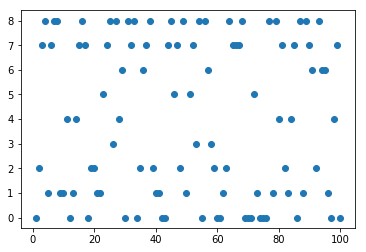

In [3]:
#x軸にid,y軸に生存種子数を指定
plt.scatter(data.id, data.y)

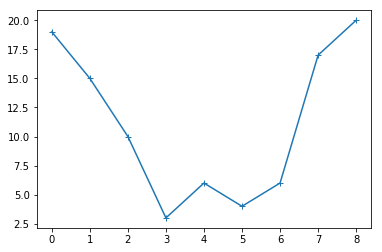

In [4]:
#x軸に生存種子数,y軸に頻度
plt.plot(data.y.value_counts().sort_index(), marker='+')
plt.show()

In [5]:
data.y.describe()

count    100.000000
mean       4.030000
std        3.150934
min        0.000000
25%        1.000000
50%        4.000000
75%        7.000000
max        8.000000
Name: y, dtype: float64

In [11]:
#value_countsの使い方
#これをsortすればx軸が生存種子数でy軸が頻度となる
data.y.value_counts()

8    20
0    19
7    17
1    15
2    10
6     6
4     6
5     4
3     3
Name: y, dtype: int64

In [6]:
#平均
print(data.y.mean())
#分散
print(data.y.var())
#分散は2よりも大きいため過分散
#8 * 0.4 * 0.6 = 2
#GLMではなくGLMMを用いる
#計算量が多いのでMCMCを利用する

4.03
9.92838383838384


In [7]:
with pm.Model() as model:
    #βの事前分布をN(0, 100)の正規分布で設定(無情報事前分布)
    beta = pm.Normal('beta', mu=0, sd=100)
    
    #超パラメータsの(超)事前分布をU(0, 10000)の連続一様分布で設定(無情報事前分布)
    s = pm.Uniform('s', lower=0, upper=10000)
    
    #パラメータrの事前分布をN(0, s)の正規分布で設定(階層事前分布)
    r = pm.Normal('r', mu=0, sd=s, shape=len(data.y))
    
    #ロジットリンク関数を設定し、二項分布で推定する
    y = pm.Binomial('y', n=8, p=pm.invlogit(beta + r), observed=data.y.values)

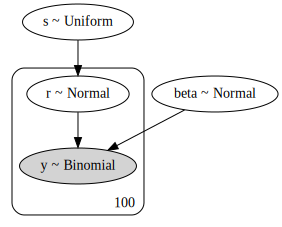

In [8]:
#モデルの可視化
pm.model_to_graphviz(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [r, s, beta]
Sampling 2 chains, 1 divergences: 100%|██████████| 3200/3200 [00:50<00:00, 63.76draws/s]
The acceptance probability does not match the target. It is 0.952468822593327, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9430825672960949, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/anaconda3/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect 

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta,0.003,0.357,-0.615,0.759,0.022,0.016,263.0,263.0,263.0,477.0,1.0
s,3.035,0.367,2.370,3.710,0.013,0.009,793.0,769.0,832.0,1283.0,1.0


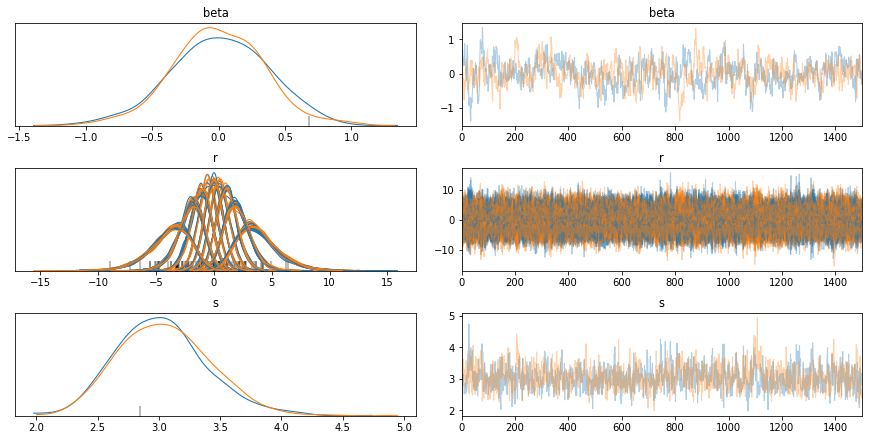

In [9]:
with model:
    #最初の100個は捨てる=101個目からサンプルとして取得する
    #NUTSで101個目からサンプルを取得するチェインを2つ作る
    trace = pm.sample(1500, tune=100)
    
_ = pm.traceplot(trace)
pm.summary(trace).loc[['beta', 's']]

#traceplotにおいてバグが存在する模様
#https://github.com/arviz-devs/arviz/issues/988

In [10]:
#サンプリングに利用したchainがリストで表示される
trace.chains

[0, 1]

In [11]:
#nchainsでchainの総数を取得できる
trace.nchains

2

In [12]:
#サンプリングした値を参照できる
print(trace.get_values('beta'))
print(trace.get_values('r'))

[ 0.68091555  0.49591096  0.63138498 ...  0.0061039  -0.05767654
 -0.32306478]
[[-3.68973452 -3.15356533  0.46990603 ... -1.26491719  2.13985583
  -2.67279853]
 [-4.13773441 -3.246683    2.12593342 ...  1.0258903   0.54457823
  -3.99262052]
 [-2.72197888 -1.2612593   0.11462549 ... -0.90441904  2.19044871
  -2.93604128]
 ...
 [-3.03616432 -1.00982739  2.21584802 ...  0.42753452  2.2238836
  -3.29952254]
 [-2.68742058 -0.81340459  0.8197219  ... -0.18188203  0.63774119
  -2.2803182 ]
 [-3.27336702 -0.51136892  2.57886622 ...  0.45824519  2.72508305
  -3.495849  ]]


In [13]:
#chainを指定しての取得も可能
print(trace.get_values('beta', chains=0))
print(len(trace.get_values('r', chains=1)))

[ 0.68091555  0.49591096  0.63138498 ...  0.08044442 -0.2968164
 -0.30312349]
1500


In [14]:
#各サンプリングの個数を取得
#指定したサンプル数 * chainの数だけ保存されている
print(len(trace.get_values('beta')))
print(len(trace.get_values('r')))

#traceの個数とchainのサンプル毎の個数は別に扱われる
print(len(trace))

3000
3000
1500


In [18]:
#事後分布p(β|Y), p(s|Y)を3つのサンプル列の平均値で求める

#まずは入れ物を作る
beta_averages = np.zeros(len(trace), dtype=np.float64)
s_averages = np.zeros(len(trace), dtype=np.float64)

In [19]:
#1500個のサンプルしたbetaおよびsを取得
#1500個づつのchainの平均を求める

for i in trace.chains:
    beta_averages += trace.get_values('beta', chains=i) / trace.nchains
    s_averages += trace.get_values('s', chains=i) / trace.nchains

In [20]:
# シグモイド関数
sigmoid = lambda beta, r: 1 / (1 + np.exp(-(beta + r)))

In [25]:
#全サンプル・全個体の種子数yの生存確率を計算
#本アプローチの考え方:
#1500のchain平均それぞれの値を基に、種子数が0から8の各場合の生存確率を求める
#その際には100個のサンプルを生成する
#つまり1500 * 100 * 9個のデータが存在する

probs = []

for (beta, s) in zip(beta_averages, s_averages):
    individuals_probs = []
    
    #s基づいて100個体を生成
    for r in norm.rvs(loc=0, scale=s, size=100):
        y_probs = []
        
        # 各個体の種子数(0〜8個)の生存確率を計算
        for y in range(9):
            y_probs.append(binom.pmf(y, 8, sigmoid(beta, r)))
            
        individuals_probs.append(y_probs)
        
    probs.append(individuals_probs)
    
probs = np.array(probs)

print(probs.shape) # (1500, 100, 9)

(1500, 100, 9)


In [42]:
#probsの中身の確認
probs[0,0,:]

array([1.23689435e-04, 2.05754460e-03, 1.49742116e-02, 6.22731202e-02,
       1.61859168e-01, 2.69248911e-01, 2.79930760e-01, 1.66306508e-01,
       4.32260868e-02])

In [47]:
print(np.average(probs, axis=0).shape)
print(np.average(probs, axis=1).shape)
print(np.average(probs, axis=2).shape)

(100, 9)
(1500, 9)
(1500, 100)


Text(0, 0.5, 'y')

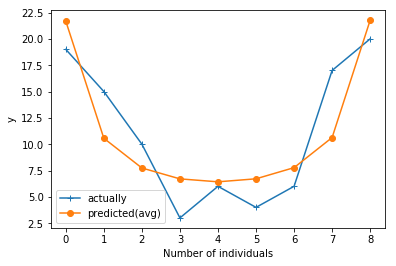

In [48]:
#ベイズ推定の推定結果はデータと近い結果になった
plt.plot(data.y.value_counts().sort_index(), marker='+', label='actually')
#100個の平均を取り(1500, 9)、その後9個の平均をとる(9)
plt.plot(np.average(np.average(probs, axis=1), axis=0) * 100, marker='o', label='predicted(avg)')
plt.legend()
plt.xlabel('Number of individuals')
plt.ylabel('y')